# Dummy avg model!

This model just takes the average of the train density as a guess for the test-set

In [71]:
import sys, os
import numpy as np
import seaborn as sns
import pandas as pd
sys.path.append('../src/')
from scf_guess_datasets import Qm9Isomeres
import matplotlib.pyplot as plt
from utils import find_repo_root
project_root_dir = find_repo_root()
print("Project root directory:", project_root_dir)

Project root directory: /home/ewachmann/REPOS/Masterarbeit


In [72]:
dataset = Qm9Isomeres(
    "/home/dmilacher/datasets/data", 
    size = 500, # number of molecules to load
    split_ratio=0.8, # using 80% training / 10 % val / 10% test split
)

In [73]:
# obtain guess iteration performance on test set
scheme_iterations = {dataset.schemes[i]: [] for i in range(len(dataset.schemes))}
for key in dataset.val_keys[len(dataset.val_keys)//2:]: #! only use half of the validation set -> which is the test set used by the model!
    for scheme, sample in dataset.guesses(key).items():
        scheme_iterations[scheme].append(sample.status.iterations)
for scheme, iterations in scheme_iterations.items():
    print(f"{scheme}: {np.mean(iterations):.2f} +- {np.std(iterations):.2f} iterations")


1e: 18.80 +- 1.82 iterations
vsap: 14.18 +- 0.93 iterations
sap: 16.56 +- 1.90 iterations
minao: 10.76 +- 0.59 iterations


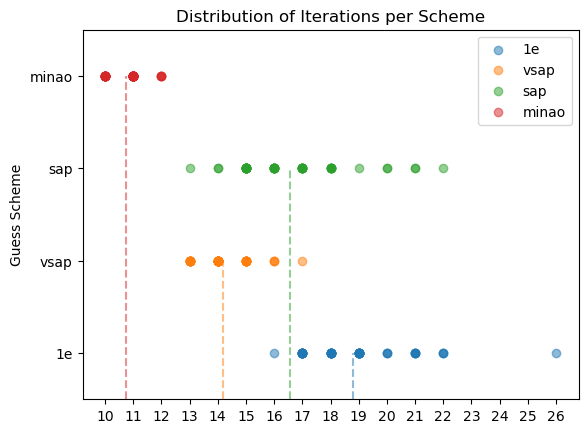

In [74]:
for i, (scheme, iterations) in enumerate(scheme_iterations.items()):
    color = plt.scatter(iterations, [scheme]*len(iterations), label=scheme, alpha=0.5).get_facecolor()[0]
    plt.vlines(np.mean(iterations), ymin=-0.5, ymax=i, colors=[color], linestyles='dashed')
plt.ylim(-0.5, len(scheme_iterations) - 0.5)
plt.xticks(np.arange(10,max([max(iterations) for iterations in scheme_iterations.values()]) + 1, 1))
plt.ylabel('Guess Scheme')
plt.title('Distribution of Iterations per Scheme')
plt.legend()

Text(0, 0.5, 'Guess Scheme')

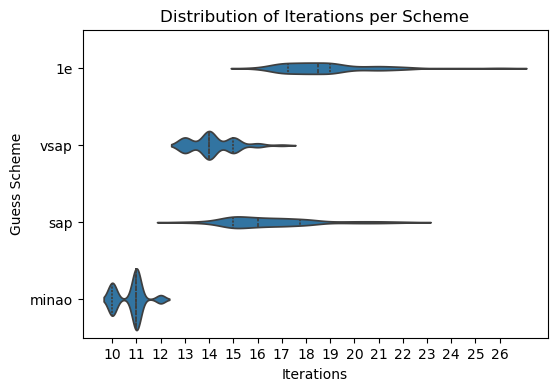

In [75]:
data = []
for scheme, iterations in scheme_iterations.items():
    for val in iterations:
        data.append({'Scheme': scheme, 'Iterations': val})
df = pd.DataFrame(data)
plt.figure(figsize=(6, 4))
sns.violinplot(data=df, x='Iterations', y='Scheme', inner='quartile', bw_method=0.3)
plt.title('Distribution of Iterations per Scheme')
plt.xlabel('Iterations')
plt.xticks(np.arange(10,max([max(iterations) for iterations in scheme_iterations.values()]) + 1, 1))
plt.ylabel('Guess Scheme')

# Mean density guess

In [76]:
from uncertainties import ufloat
import scf_guess_datasets

In [77]:
# now 0-D guess!
densities = []
for key in dataset.train_keys: 
    sample = dataset.solution(key)
    densities.append(sample.density)
densities = np.array(densities)
mean_density = np.mean(densities, axis=0)
iterations = []

In [79]:
test_keys = dataset.val_keys[len(dataset.val_keys)//2:]
for i, key in enumerate(test_keys):
    solver = dataset.solver(test_keys[i])
    overlap, hcore, density, fock, status = scf_guess_datasets.solve(solver, mean_density.astype(np.float64))
    iterations.append(status.iterations)
    print(f"Sample {i}: Cycles with 0D guess: {status.iterations}")

Sample 0: Cycles with 0D guess: 19
Sample 1: Cycles with 0D guess: 17
Sample 2: Cycles with 0D guess: 18
Sample 3: Cycles with 0D guess: 16
Sample 4: Cycles with 0D guess: 17
Sample 5: Cycles with 0D guess: 17
Sample 6: Cycles with 0D guess: 21
Sample 7: Cycles with 0D guess: 17
Sample 8: Cycles with 0D guess: 16
Sample 9: Cycles with 0D guess: 20
Sample 10: Cycles with 0D guess: 17
Sample 11: Cycles with 0D guess: 16
Sample 12: Cycles with 0D guess: 17
Sample 13: Cycles with 0D guess: 16
Sample 14: Cycles with 0D guess: 17
Sample 15: Cycles with 0D guess: 16
Sample 16: Cycles with 0D guess: 16
Sample 17: Cycles with 0D guess: 16
Sample 18: Cycles with 0D guess: 15
Sample 19: Cycles with 0D guess: 18
Sample 20: Cycles with 0D guess: 17
Sample 21: Cycles with 0D guess: 19
Sample 22: Cycles with 0D guess: 17
Sample 23: Cycles with 0D guess: 16
Sample 24: Cycles with 0D guess: 18
Sample 25: Cycles with 0D guess: 17
Sample 26: Cycles with 0D guess: 17
Sample 27: Cycles with 0D guess: 16
Sa

In [80]:
mean_own = np.mean(iterations)
std_own = np.std(iterations)
iter_own = ufloat(mean_own, std_own)
print(f"Average iterations with own guess: {iter_own:.2f}")
import pickle
with open(f"{project_root_dir}/3_studies/Block_guessing/models/0D_cycles.pkl", "wb") as f:
    pickle.dump(iterations, f)

Average iterations with own guess: 17.10+/-1.45
